In [1]:
## Import Python libraries ## 
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import extra_func as ext

import xarray as xr
import xsimlab as xs
%reload_ext xsimlab.ipython

import fastscape
from fastscape.models import basic_model
from fastscape.processes import StreamPowerChannelTD
from fastscape.processes import MarineSedimentTransport
from fastscape.processes import Sea
from fastscape.processes import Bedrock

from adascape.fastscape_ext import IR12Speciation
from adascape.fastscape_ext import ElevationEnvField
from adascape.fastscape_ext import CompoundEnvironment
from adascape.fastscape_ext import RandomSeedFederation
from adascape.fastscape_ext import FastscapeElevationTrait

In [2]:
## Set of plotting functions for life output ##

def get_dataframe(ds, out_vars=['life__taxon_id', 'life__ancestor_id',
                                'life__trait_elev', 'life__y', 'life__x']):
    """
    Function to convert xarray.Dataset with results of a couple eco-evolutionary model with FastScape LEM

    Parameters
    ----------
    ds: xr.Dataset
             with results of the eco-evo model
    out_vars: list-like
              with variable to be extracted. The variable names must be equal as they appear in ds
    Returns
    -------
    pandas.DataFrame with columns out (time step), taxon_id, ancestor_id, trait associated with elevation (trait_elev)
    trait associated with precipitation (trait_prep), x and y location of individuals
    """
    individuals_data = {}
    for i in range(ds.life__traits.shape[2]):
        individuals_data['life__' + str(ds.trait[i].values.astype(str))] = ds.life__traits[:, :, i]
    ds = ds.assign(individuals_data)
    out_ds = ds[out_vars]

    dtf = (
        out_ds
            .to_dataframe()
            .rename(columns=lambda name: name.replace('life__', ''))
            .reset_index()
            .dropna()
            .drop('ind', axis=1)
    )
    return dtf

def plot_topo_taxa(ds, dtf, time_sel):
    """
    Function to plot the spatial distribution of taxa, where the taxa are depicted with different markers and
    colors.

    Parameters
    ----------
     ds: xr.Dataset
             with results of the eco-evo model
     dtf: pd.DataFrame
         with results of the eco-evo model
     time_sel: array-like
               with time steps to plot the results
    """
    mkrs = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8',
            's', 'p', '*', '+', 'h', 'H', 'D', 'd', 'P', 'X',
            0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    fig1 = (ds
            .sel(output=time_sel)
            .topography__elevation.plot(col='output', col_wrap=3, aspect=ny/nx, cmap='bone', vmin=-500, vmax=2000)
            )

    for ax1, t in zip(fig1.axes.ravel(), time_sel):
        pop = dtf[dtf.output == t].groupby('taxon_id')
        max_no_grp = max(list(pop.groups.keys()))
        for k, v in pop:
            ax1.scatter(v.x, v.y, marker=mkrs[int(max_no_grp - k)], s=20)

def plot_temp_dyn_2traits(dtf):
    """
    Function to plot the abundance, richness and trait distribution through time and along the Y coordinate.

    Parameters
    ----------
    dtf: pd.DataFrame
         with results of the speciation model
    """
    fig2, axs2 = plt.subplots(3, 3, sharex="col", figsize=(18, 6))
    gs2 = axs2[1, 1].get_gridspec()
    for ax in axs2[0:, 1:].flatten():
        ax.remove()
    axbig0 = fig2.add_subplot(gs2[0:, -2])
    axbig1 = fig2.add_subplot(gs2[0:, -1])
    axs2[0, 0].plot(dtf.groupby('output').size())
    axs2_2 = axs2[0, 0].twinx()
    axs2_2.plot(dtf.groupby(['output']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
    h, xedge, yedge, _ = axs2[1, 0].hist2d(x=dtf['output'], y=dtf['trait_elev'],
                                           range=((0, 1e6), (0, 1)),
                                           bins=(100, 100), cmap='bone_r')
    # h, xedge, yedge, _ = axs2[2, 0].hist2d(x=dtf['out'], y=dtf['trait_prep'],
    #                                        range=((0, 1e6), (0, 1)),
    #                                        bins=(100, 100), cmap='bone_r')
    h, xedge, yedge, _ = axbig0.hist2d(x=dtf['trait_elev'].loc[dtf['output'] == max(dtf['output'])],
                                       y=dtf['y'].loc[dtf['output'] == max(dtf['output'])],
                                       range=((0, 1), (0, 1e5)),
                                       bins=(100, 100), cmap='bone_r')
    # h, xedge, yedge, _ = axbig1.hist2d(x=dtf['trait_prep'].loc[dtf['out'] == max(dtf['out'])],
    #                                    y=dtf['y'].loc[dtf['out'] == max(dtf['out'])],
    #                                    range=((0, 1), (0, 1e5)),
    #                                    bins=(100, 100), cmap='bone_r')
    axbig0.yaxis.set_tick_params(labelleft=False)
    axbig1.yaxis.set_label_position("right")
    axbig0.yaxis.tick_right()
    axbig1.yaxis.tick_right()
    axbig0.set_xlabel('Trait\nElevation', weight='bold')
    # axbig1.set_xlabel('Trait\nPrecipitation', weight='bold')
    axbig1.set_ylabel('Y [m]', weight='bold')
    axs2[0, 0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
    axs2_2.set_ylabel('Taxon richness', weight='bold', color='red')
    axs2[1, 0].set_ylabel('Trait\nElevation', weight='bold')
    axs2[2, 0].set_ylabel('Trait\nPrecipitation', weight='bold')
    axs2[2, 0].set_xlabel('Time [years]', weight='bold')

In [3]:
## Check versions ##

print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [4]:
## Build xarray-simlab model ##
TurkeyLEM = basic_model.drop_processes(['init_topography'])
TurkeyLEM = TurkeyLEM.update_processes({'spl': StreamPowerChannelTD})
TurkeyLEM = TurkeyLEM.update_processes({'bedrock': Bedrock})
TurkeyLEM = TurkeyLEM.update_processes({'sea_level': Sea})
TurkeyLEM = TurkeyLEM.update_processes({'marine': MarineSedimentTransport})
TurkeyLEM = TurkeyLEM.update_processes({'life': IR12Speciation})
TurkeyLEM = TurkeyLEM.update_processes({'random': RandomSeedFederation})
TurkeyLEM = TurkeyLEM.update_processes({'trait_elev': FastscapeElevationTrait})
TurkeyLEM = TurkeyLEM.update_processes({'env_field': CompoundEnvironment})
TurkeyLEM = TurkeyLEM.update_processes({'elev_field': ElevationEnvField})

TurkeyLEM

<xsimlab.Model (23 processes, 45 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
flow
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
    tol_rel              [in] relative tolerance (Gauss-Siedel conv...
    tol_abs              [in] absolute tolerance (Gauss-Siedel conv...
    max_iter             [in] max nb. of iterations (Gauss-Siedel c...
    g_coef               [in] detached bedrock transport/deposition...
init_erosion
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
marine
    ss_ratio_land        [in] silt fraction of continental se

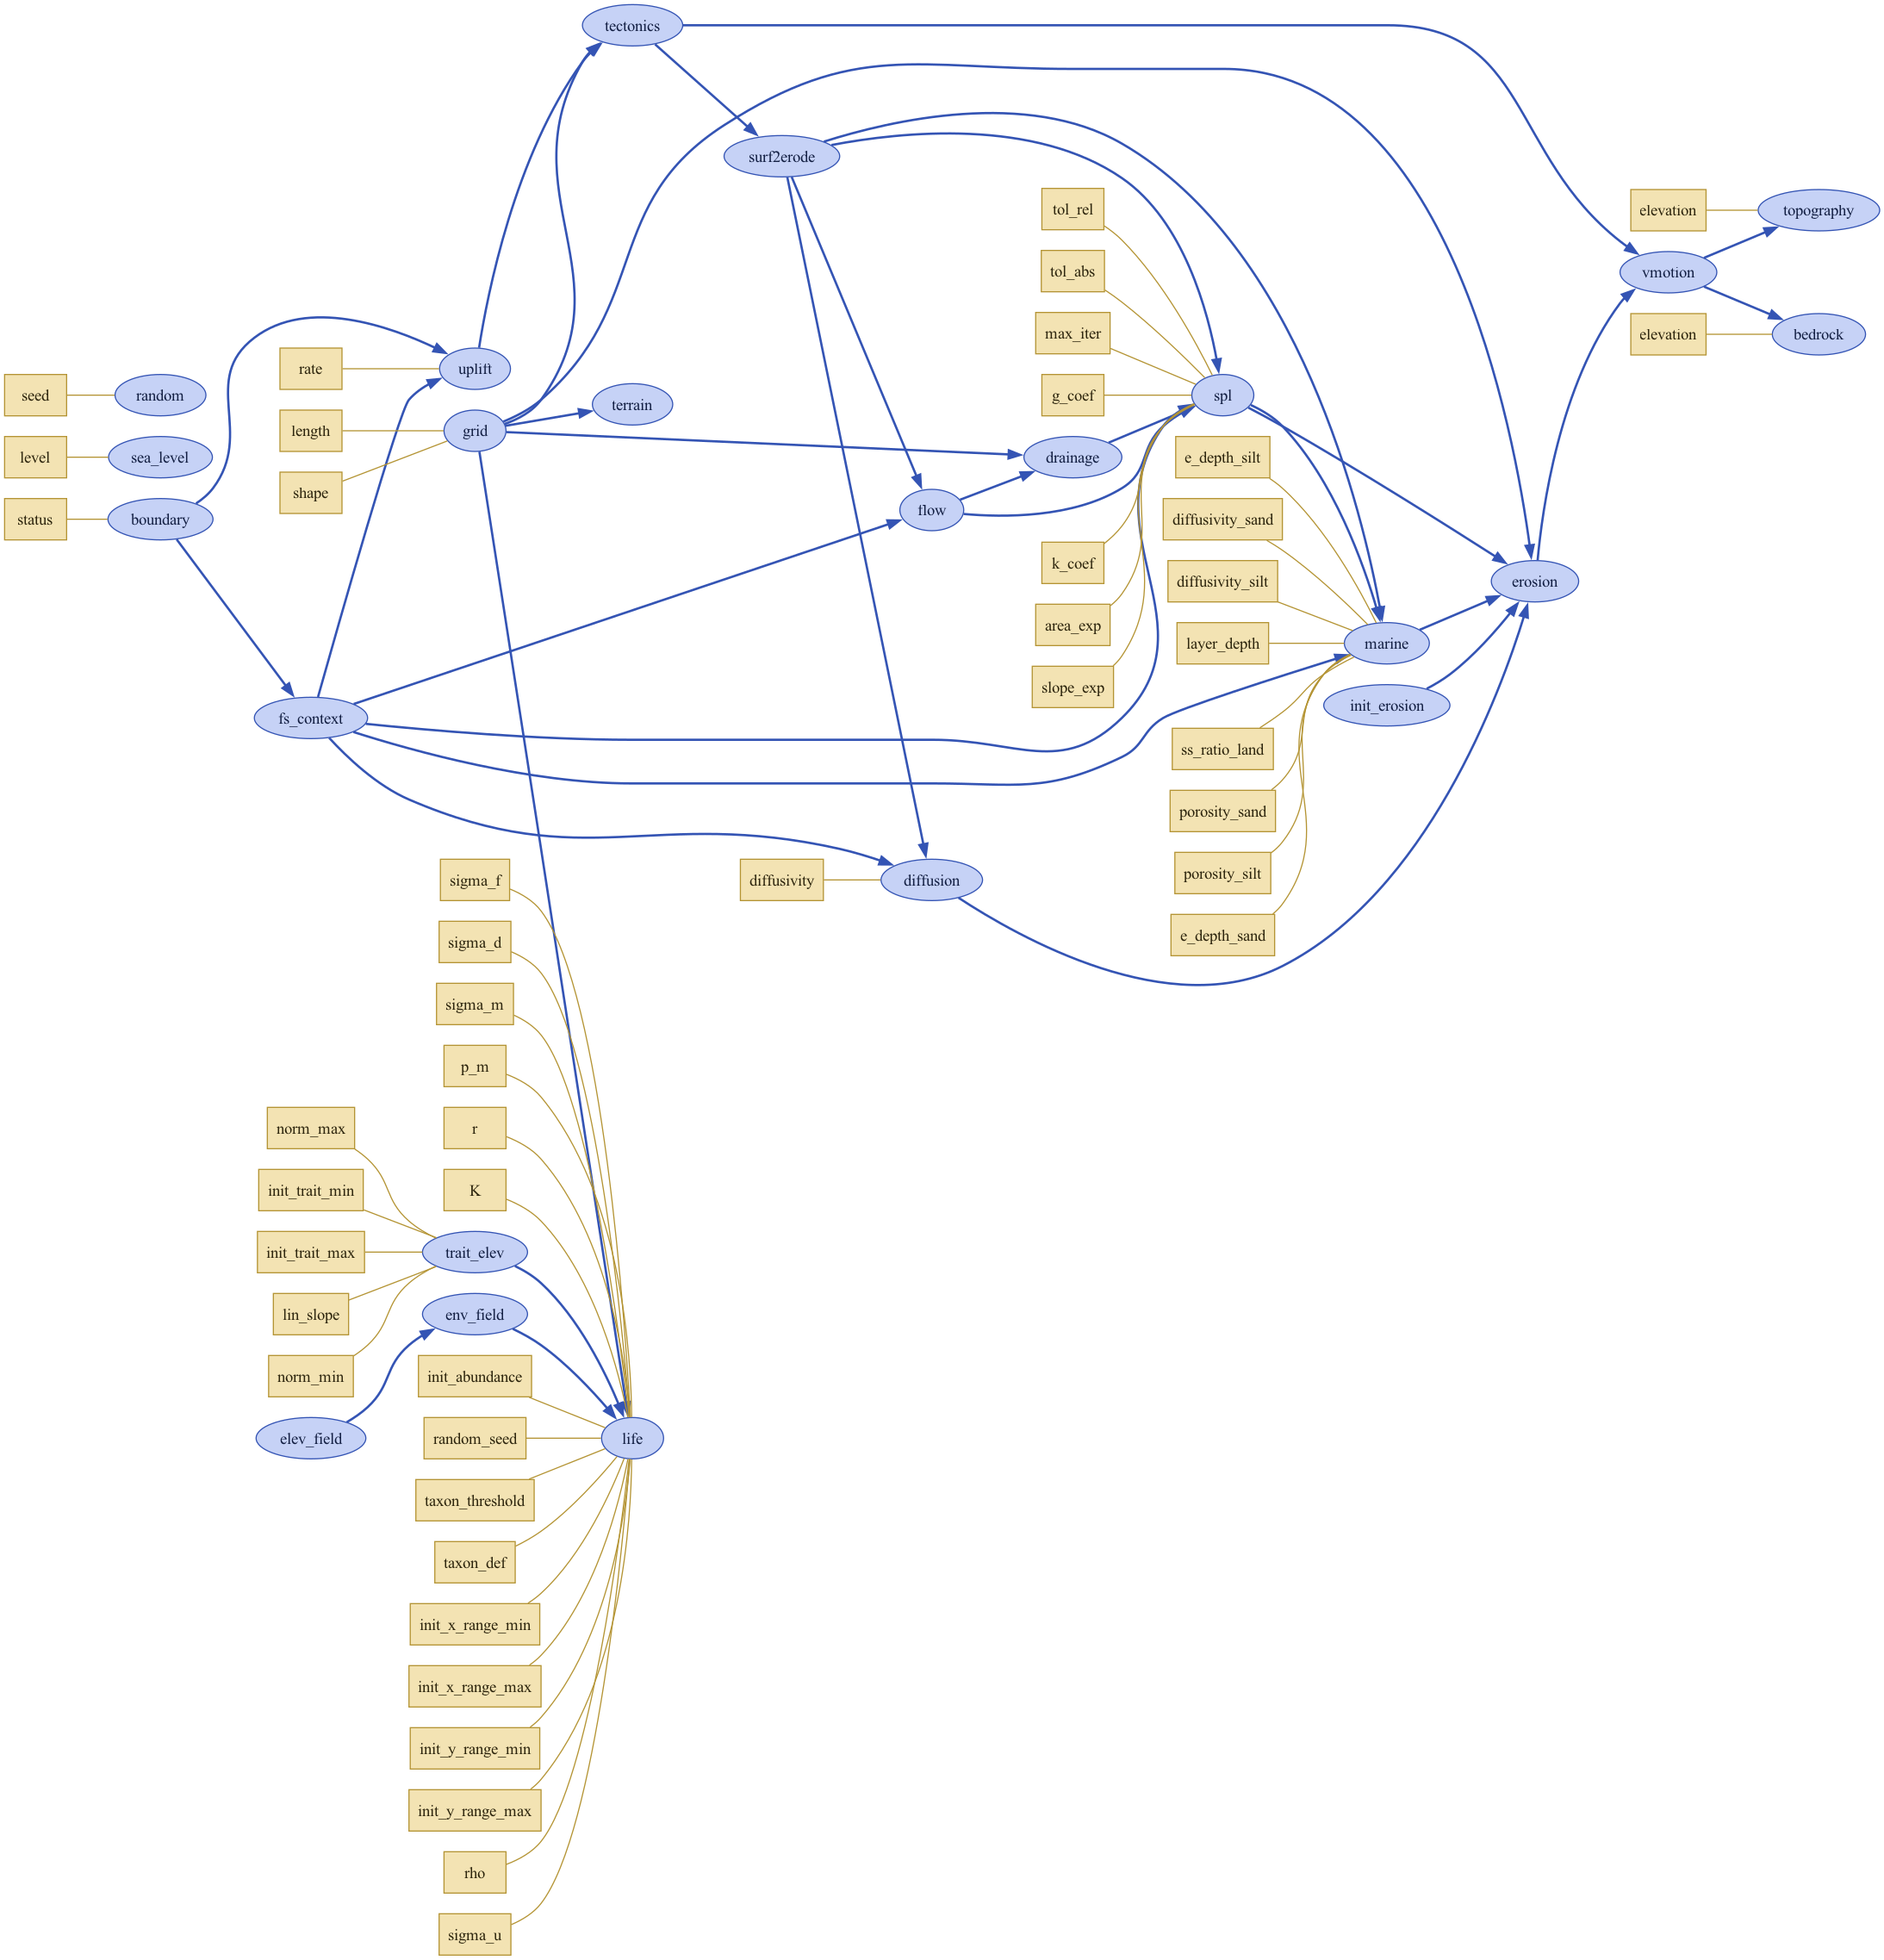

In [5]:
## Visualise xarray-simlab ##
TurkeyLEM.visualize(show_inputs='True')

In [6]:
## Model dimensions ##
nx = 745
ny = 1384
nn = nx * ny

xl = 745.e3
yl = 1384.e3 

BoundaryCondition = ['fixed_value', 'core', 'fixed_value', 'core']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Fluvial erosion ##
kf_bedrock = 2e-5
kf_soil = 2e-4
g_bedrock = 1
g_soil = 1

m = 0.5
n = 1

## Hillslope diffusion ##
kd_bedrock = 2e-6
kd_soil = 2e-5

## Marine parameters ##
Silt_FractionOnLand = 0.5
Sand_Porosity = 0
Silt_Porosity = 0
Sand_eDepth = 500
Silt_eDepth = 500
# issue with diffusivity not being equal for both sand and silt, need to increase time steps, issues with sea level depths (too deep may crash the model)
Sand_Diffusivity = 5e2
Silt_Diffusivity = 2.5e2
ActiveLayerDepth = 1e2

## Life ##
InitialAbundance = 10
TaxonThreshold = 0.095
TaxonDefinition = 'traits'
InitialSpecies_xmin = None
InitialSpecies_xmax = None
InitialSpecies_ymin = None
InitialSpecies_ymax = None
TraitCorrelationCoefficient = 0
TraitMediatedCompetition = 0.2
FitnessSelectivity = 0.25
DispersalVariability = 1e5
OffspringVariability = 0.05
MutationProbability = 0.005
NeighbourhoodRadius = 1e5
NeighbourhoodCapacity = 25

## Elevation Traits ##
InitialTraitMinimum = 0.25
InitialTraitMaximum = 0.25
Slope_TraitvsElevation = 0.95
MinimumElevationNormalisation = 0
MaximumElevationNormalisation = 3700

## Initial topography ##
WhiteNoiseLevel = 50 # in [m]

## Others ##
RandomSeed = 1410

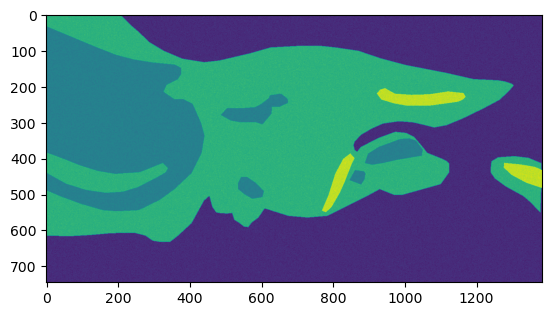

In [7]:
# TopographyInput_1 = Image.open('13Ma_Sedimentation_LowRes.tiff')
# TopographyInput_2 = Image.open('13Ma_Lowlands_LowRes.tiff')
# TopographyInput_3 = Image.open('13Ma_Highlands_LowRes.tiff')

TopographyInput_1 = Image.open('13Ma_Sedimentation.tiff')
TopographyInput_2 = Image.open('13Ma_Lowlands.tiff')
TopographyInput_3 = Image.open('13Ma_Highlands.tiff')

# User input
TopographyInput_0_Elevation = -500
TopographyInput_1_Elevation = 100
TopographyInput_2_Elevation = 500
TopographyInput_3_Elevation = 1000

TopographyArray_1 = np.array(TopographyInput_1)
TopographyArray_1 = np.flip(TopographyArray_1, 1)
TopographyArray_2 = np.array(TopographyInput_2)
TopographyArray_2 = np.flip(TopographyArray_2, 1)
TopographyArray_3 = np.array(TopographyInput_3)
TopographyArray_3 = np.flip(TopographyArray_3, 1)

TopographyArray_1_rearranged = TopographyArray_1.reshape(nn, 4)
TopographyArray_2_rearranged = TopographyArray_2.reshape(nn, 4)
TopographyArray_3_rearranged = TopographyArray_3.reshape(nn, 4)

InitialTopography = np.zeros(nn)

for i in range(0,nn):
        if (TopographyArray_1_rearranged[i,0] == 0) & (TopographyArray_1_rearranged[i,1] == 0) & (TopographyArray_1_rearranged[i,2] == 0) & (TopographyArray_1_rearranged[i,3] == 255) & (InitialTopography[i] == 0.0):
               InitialTopography[i] = TopographyInput_1_Elevation
for i in range(0,nn):
        if (TopographyArray_2_rearranged[i,0] == 0) & (TopographyArray_2_rearranged[i,1] == 0) & (TopographyArray_2_rearranged[i,2] == 0) & (TopographyArray_2_rearranged[i,3] == 255) & (InitialTopography[i] == 0.0):
                InitialTopography[i] = TopographyInput_2_Elevation
for i in range(0,nn):
        if (TopographyArray_3_rearranged[i,0] == 0) & (TopographyArray_3_rearranged[i,1] == 0) & (TopographyArray_3_rearranged[i,2] == 0) & (TopographyArray_3_rearranged[i,3] == 255):
                InitialTopography[i] = TopographyInput_3_Elevation
for i in range(0,nn):
        if (InitialTopography[i] == 0.0):
                InitialTopography[i] = TopographyInput_0_Elevation

np.random.seed(RandomSeed)
Noise = np.random.normal(0,WhiteNoiseLevel, nn)

InitialTopography = InitialTopography + Noise
InitialTopography = np.flip(InitialTopography)
InitialTopography = InitialTopography.reshape(nx,ny)
InitialTopography = np.flipud(InitialTopography)

plt.imshow(InitialTopography)
plt.show()

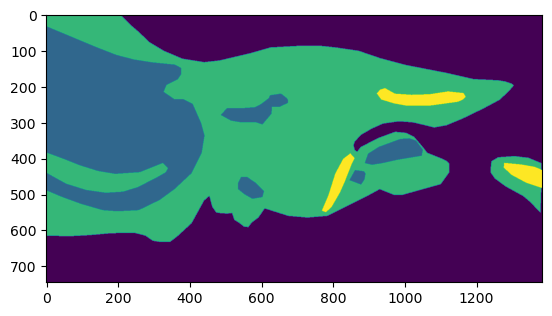

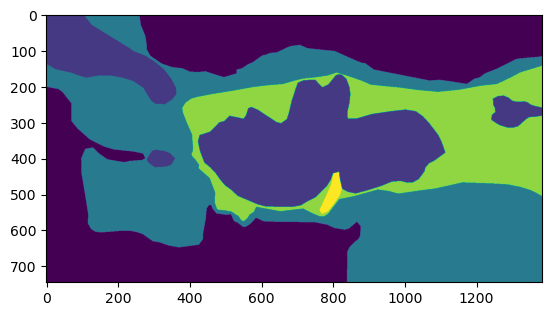

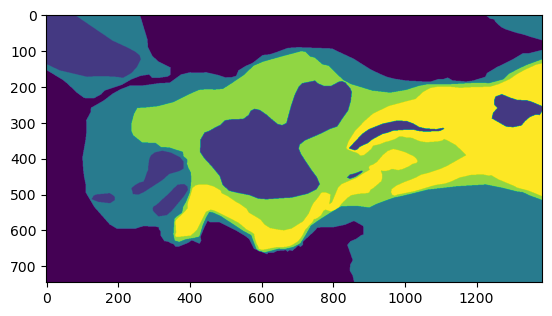

In [8]:
# First stage surface uplift

# UpliftInput_1a = Image.open('13Ma_Sedimentation_LowRes.tiff')
# UpliftInput_1b = Image.open('13Ma_Lowlands_LowRes.tiff')
# UpliftInput_1c = Image.open('13Ma_Highlands_LowRes.tiff')

UpliftInput_1a = Image.open('13Ma_Sedimentation.tiff')
UpliftInput_1b = Image.open('13Ma_Lowlands.tiff')
UpliftInput_1c = Image.open('13Ma_Highlands.tiff')

UpliftInput_0_Rate = 1e-6
UpliftInput_1_Rate = 1e-3
UpliftInput_2_Rate = 2e-3
UpliftInput_3_Rate = 3e-3
UpliftInput_4_Rate = 5e-3

UpliftArray_1a = np.array(UpliftInput_1a)
UpliftArray_1a = np.flip(UpliftArray_1a,1)
UpliftArray_1b = np.array(UpliftInput_1b)
UpliftArray_1b = np.flip(UpliftArray_1b,1)
UpliftArray_1c = np.array(UpliftInput_1c)
UpliftArray_1c = np.flip(UpliftArray_1c,1)

UpliftArray_1a_rearranged = UpliftArray_1a.reshape(nn, 4)
UpliftArray_1b_rearranged = UpliftArray_1b.reshape(nn, 4)
UpliftArray_1c_rearranged = UpliftArray_1c.reshape(nn, 4)

SurfaceUplift_1 = np.zeros(nn)

# Initiation
for i in range(0,nn):
    if (UpliftArray_1a_rearranged[i,0] == 0) & (UpliftArray_1a_rearranged[i,1] == 0) & (UpliftArray_1a_rearranged[i,2] == 0) & (UpliftArray_1a_rearranged[i,3] == 255) & (SurfaceUplift_1[i] == 0.0):
        SurfaceUplift_1[i] = UpliftInput_1_Rate
for i in range(0,nn):
    if (UpliftArray_1b_rearranged[i,0] == 0) & (UpliftArray_1b_rearranged[i,1] == 0) & (UpliftArray_1b_rearranged[i,2] == 0) & (UpliftArray_1b_rearranged[i,3] == 255) & (SurfaceUplift_1[i] == 0.0):
        SurfaceUplift_1[i] = UpliftInput_2_Rate
for i in range(0,nn):
    if (UpliftArray_1c_rearranged[i,0] == 0) & (UpliftArray_1c_rearranged[i,1] == 0) & (UpliftArray_1c_rearranged[i,2] == 0) & (UpliftArray_1c_rearranged[i,3] == 255):
        SurfaceUplift_1[i] = UpliftInput_3_Rate
for i in range(0,nn):
    if (SurfaceUplift_1[i] == 0.0):
        SurfaceUplift_1[i] = UpliftInput_0_Rate

SurfaceUplift_1 = np.flip(SurfaceUplift_1)
SurfaceUplift_1 = SurfaceUplift_1.reshape(nx,ny)
SurfaceUplift_1 = np.flipud(SurfaceUplift_1)

# Second stage surface uplift
UpliftInput_2a = Image.open('8Ma_Sedimentation.tiff')
UpliftInput_2b = Image.open('8Ma_Lowlands.tiff')
UpliftInput_2c = Image.open('8Ma_Highlands.tiff')
UpliftInput_2d = Image.open('8Ma_Alpine.tiff')

UpliftInput_0_Rate = 1e-6
UpliftInput_1_Rate = 1e-3
UpliftInput_2_Rate = 2.5e-3
UpliftInput_3_Rate = 5e-3
UpliftInput_4_Rate = 6e-3

UpliftArray_2a = np.array(UpliftInput_2a)
UpliftArray_2a = np.flip(UpliftArray_2a,1)
UpliftArray_2b = np.array(UpliftInput_2b)
UpliftArray_2b = np.flip(UpliftArray_2b,1)
UpliftArray_2c = np.array(UpliftInput_2c)
UpliftArray_2c = np.flip(UpliftArray_2c,1)
UpliftArray_2d = np.array(UpliftInput_2d)
UpliftArray_2d = np.flip(UpliftArray_2d,1)

UpliftArray_2a_rearranged = UpliftArray_2a.reshape(nn, 4)
UpliftArray_2b_rearranged = UpliftArray_2b.reshape(nn, 4)
UpliftArray_2c_rearranged = UpliftArray_2c.reshape(nn, 4)
UpliftArray_2d_rearranged = UpliftArray_2d.reshape(nn, 4)

SurfaceUplift_2 = np.zeros(nn)

# Step 1
for i in range(0,nn):
    if (UpliftArray_2b_rearranged[i,0] == 0) & (UpliftArray_2b_rearranged[i,1] == 0) & (UpliftArray_2b_rearranged[i,2] == 0) & (UpliftArray_2b_rearranged[i,3] == 255):
        SurfaceUplift_2[i] = UpliftInput_2_Rate
for i in range(0,nn):
    if (UpliftArray_2c_rearranged[i,0] == 0) & (UpliftArray_2c_rearranged[i,1] == 0) & (UpliftArray_2c_rearranged[i,2] == 0) & (UpliftArray_2c_rearranged[i,3] == 255):
        SurfaceUplift_2[i] = UpliftInput_3_Rate
for i in range(0,nn):
    if (UpliftArray_2a_rearranged[i,0] == 0) & (UpliftArray_2a_rearranged[i,1] == 0) & (UpliftArray_2a_rearranged[i,2] == 0) & (UpliftArray_2a_rearranged[i,3] == 255):
        SurfaceUplift_2[i] = UpliftInput_1_Rate
for i in range(0,nn):
    if (UpliftArray_2d_rearranged[i,0] == 0) & (UpliftArray_2d_rearranged[i,1] == 0) & (UpliftArray_2d_rearranged[i,2] == 0) & (UpliftArray_2d_rearranged[i,3] == 255):
        SurfaceUplift_2[i] = UpliftInput_4_Rate
for i in range(0,nn):
    if (SurfaceUplift_2[i] == 0.0):
        SurfaceUplift_2[i] = UpliftInput_0_Rate

SurfaceUplift_2 = np.flip(SurfaceUplift_2)
SurfaceUplift_2 = SurfaceUplift_2.reshape(nx,ny)
SurfaceUplift_2 = np.flipud(SurfaceUplift_2)

# Third stage surface uplift
UpliftInput_3a = Image.open('5Ma_Sedimentation.tiff')
UpliftInput_3b = Image.open('5Ma_Lowlands.tiff')
UpliftInput_3c = Image.open('5Ma_Highlands.tiff')
UpliftInput_3d = Image.open('5Ma_Alpine.tiff')

UpliftInput_0_Rate = 1e-6
UpliftInput_1_Rate = 1e-3
UpliftInput_2_Rate = 2.5e-3
UpliftInput_3_Rate = 5e-3
UpliftInput_4_Rate = 6e-3

UpliftArray_3a = np.array(UpliftInput_3a)
UpliftArray_3a = np.flip(UpliftArray_3a,1)
UpliftArray_3b = np.array(UpliftInput_3b)
UpliftArray_3b = np.flip(UpliftArray_3b,1)
UpliftArray_3c = np.array(UpliftInput_3c)
UpliftArray_3c = np.flip(UpliftArray_3c,1)
UpliftArray_3d = np.array(UpliftInput_3d)
UpliftArray_3d = np.flip(UpliftArray_3d,1)

UpliftArray_3a_rearranged = UpliftArray_3a.reshape(nn, 4)
UpliftArray_3b_rearranged = UpliftArray_3b.reshape(nn, 4)
UpliftArray_3c_rearranged = UpliftArray_3c.reshape(nn, 4)
UpliftArray_3d_rearranged = UpliftArray_3d.reshape(nn, 4)

SurfaceUplift_3 = np.zeros(nn)

for i in range(0,nn):
    if (UpliftArray_3b_rearranged[i,0] == 0) & (UpliftArray_3b_rearranged[i,1] == 0) & (UpliftArray_3b_rearranged[i,2] == 0) & (UpliftArray_3b_rearranged[i,3] == 255):
        SurfaceUplift_3[i] = UpliftInput_2_Rate
for i in range(0,nn):
    if (UpliftArray_3c_rearranged[i,0] == 0) & (UpliftArray_3c_rearranged[i,1] == 0) & (UpliftArray_3c_rearranged[i,2] == 0) & (UpliftArray_3c_rearranged[i,3] == 255):
        SurfaceUplift_3[i] = UpliftInput_3_Rate
for i in range(0,nn):
    if (UpliftArray_3d_rearranged[i,0] == 0) & (UpliftArray_3d_rearranged[i,1] == 0) & (UpliftArray_3d_rearranged[i,2] == 0) & (UpliftArray_3d_rearranged[i,3] == 255):
        SurfaceUplift_3[i] = UpliftInput_4_Rate
for i in range(0,nn):
    if (UpliftArray_3a_rearranged[i,0] == 0) & (UpliftArray_3a_rearranged[i,1] == 0) & (UpliftArray_3a_rearranged[i,2] == 0) & (UpliftArray_3a_rearranged[i,3] == 255):
        SurfaceUplift_3[i] = UpliftInput_1_Rate
for i in range(0,nn):
    if (SurfaceUplift_3[i] == 0.0):
        SurfaceUplift_3[i] = UpliftInput_0_Rate

SurfaceUplift_3 = np.flip(SurfaceUplift_3)
SurfaceUplift_3 = SurfaceUplift_3.reshape(nx,ny)
SurfaceUplift_3 = np.flipud(SurfaceUplift_3)

plt.imshow(SurfaceUplift_1)
plt.show()
plt.imshow(SurfaceUplift_2)
plt.show()
plt.imshow(SurfaceUplift_3)
plt.show()

In [9]:
## Set up input parameters for xarray-simlab model ##
in_ds_S1 = xs.create_setup(
    model = TurkeyLEM,
    clocks={
        'time': ModelTime_1,
        'output': ModelTime_1[::PlotStep]
    },
    master_clock='time',
    input_vars={
        'grid': {
            'shape': [nx, ny],
            'length': [xl, yl],
        },
        'boundary': {
            'status': BoundaryCondition
        },
        'topography': {
            'elevation': InitialTopography,
        },
        'bedrock': {
            'elevation': InitialTopography,
        },
        'uplift': {
            'rate': SurfaceUplift_1,
        },
        'spl': {
            'k_coef': kf_bedrock,
            'area_exp': m,
            'slope_exp': n,
            'g_coef': g_bedrock,
        },
        'diffusion': {
            'diffusivity': kd_bedrock,
        },
        'marine': {
            'ss_ratio_land': Silt_FractionOnLand,
            'porosity_sand': Sand_Porosity,
            'porosity_silt': Silt_Porosity,
            'e_depth_sand': Sand_eDepth,
            'e_depth_silt': Silt_eDepth,
            # issue with diffusivity not being equal for both sand and silt, need to increase time steps, issues with sea level depths (too deep may crash the model)
            'diffusivity_sand': Sand_Diffusivity, 
            'diffusivity_silt': Silt_Diffusivity,
            'layer_depth': ActiveLayerDepth,
        },
        'life': {
            'init_abundance': InitialAbundance,
            'random_seed': RandomSeed,
            'taxon_threshold': TaxonThreshold,
            'taxon_def': TaxonDefinition,
            'init_x_range_min': InitialSpecies_xmin,
            'init_x_range_max': InitialSpecies_xmax,
            'init_y_range_min': InitialSpecies_ymin,
            'init_y_range_max': InitialSpecies_ymax,
            'rho': TraitCorrelationCoefficient,
            'sigma_u': TraitMediatedCompetition,
            'sigma_f': FitnessSelectivity,
            'sigma_d': DispersalVariability,
            'sigma_m': OffspringVariability,
            'p_m': MutationProbability,
            'r': NeighbourhoodRadius,
            'K': NeighbourhoodCapacity
        },
        'random': {
            'seed': RandomSeed,
        },
        'trait_elev': {
            'init_trait_min': InitialTraitMinimum,
            'init_trait_max': InitialTraitMaximum,
            'lin_slope': Slope_TraitvsElevation,
            'norm_min': MinimumElevationNormalisation,
            'norm_max': MaximumElevationNormalisation,
        },
    },
    output_vars={
        'topography': {
            'elevation': 'output'
        },
        'bedrock': {
            'elevation': 'output'
        },
        'life': {
            'x': 'output',
            'y': 'output',
            'traits': 'output',
            'taxon_id': 'output',
            'ancestor_id': 'output'
        }
    }
)

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'output' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [10]:
in_ds_S1

<xarray.Dataset> Size: 25MB
Dimensions:                     (time: 10001, output: 101, shape_yx: 2,
                                 border: 4, y: 745, x: 1384)
Coordinates:
  * time                        (time) float64 80kB 0.0 500.0 ... 5e+06 5e+06
  * output                      (output) float64 808B 0.0 5e+04 ... 5e+06
Dimensions without coordinates: shape_yx, border, y, x
Data variables: (12/45)
    spl__tol_rel                float64 8B 0.0001
    spl__tol_abs                float64 8B 0.0001
    spl__max_iter               int64 8B 100
    sea_level__level            float64 8B 0.0
    grid__shape                 (shape_yx) int64 16B 745 1384
    grid__length                (shape_yx) float64 16B 7.45e+05 1.384e+06
    ...                          ...
    random__seed                int64 8B 1410
    trait_elev__init_trait_min  float64 8B 0.25
    trait_elev__init_trait_max  float64 8B 0.25
    trait_elev__lin_slope       float64 8B 0.95
    trait_elev__norm_min        int64 8B 0
    trait_elev__norm_max        int64 8B 3700

In [11]:
with xs.monitoring.ProgressBar():
    out_ds_S1 = in_ds_S1.xsimlab.run(model=TurkeyLEM)
    
out_ds_S1

             0% | initialize 

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


<xarray.Dataset> Size: 2GB
Dimensions:                     (output: 101, y: 745, x: 1384, border: 4,
                                 shape_yx: 2, ind: 1234, trait: 1, time: 10001)
Coordinates:
  * border                      (border) object 32B 'left' 'right' ... 'bottom'
  * output                      (output) float64 808B 0.0 5e+04 ... 5e+06
  * time                        (time) float64 80kB 0.0 500.0 ... 5e+06 5e+06
  * trait                       (trait) object 8B b'trait_elev'
  * x                           (x) float64 11kB 0.0 1.001e+03 ... 1.384e+06
  * y                           (y) float64 6kB 0.0 1.001e+03 ... 7.45e+05
Dimensions without coordinates: shape_yx, ind
Data variables: (12/50)
    bedrock__elevation          (output, y, x) float64 833MB -416.0 ... -565.6
    boundary__status            (border) <U11 176B 'fixed_value' ... 'core'
    diffusion__diffusivity      float64 8B 2e-06
    grid__length                (shape_yx) float64 16B 7.45e+05 1.384e+06
    grid__shape                 (shape_yx) int64 16B 745 1384
    life__K                     int64 8B 25
    ...                          ...
    trait_elev__init_trait_max  float64 8B 0.25
    trait_elev__init_trait_min  float64 8B 0.25
    trait_elev__lin_slope       float64 8B 0.95
    trait_elev__norm_max        int64 8B 3700
    trait_elev__norm_min        int64 8B 0
    uplift__rate                (y, x) float64 8MB 1e-06 1e-06 ... 1e-06 1e-06

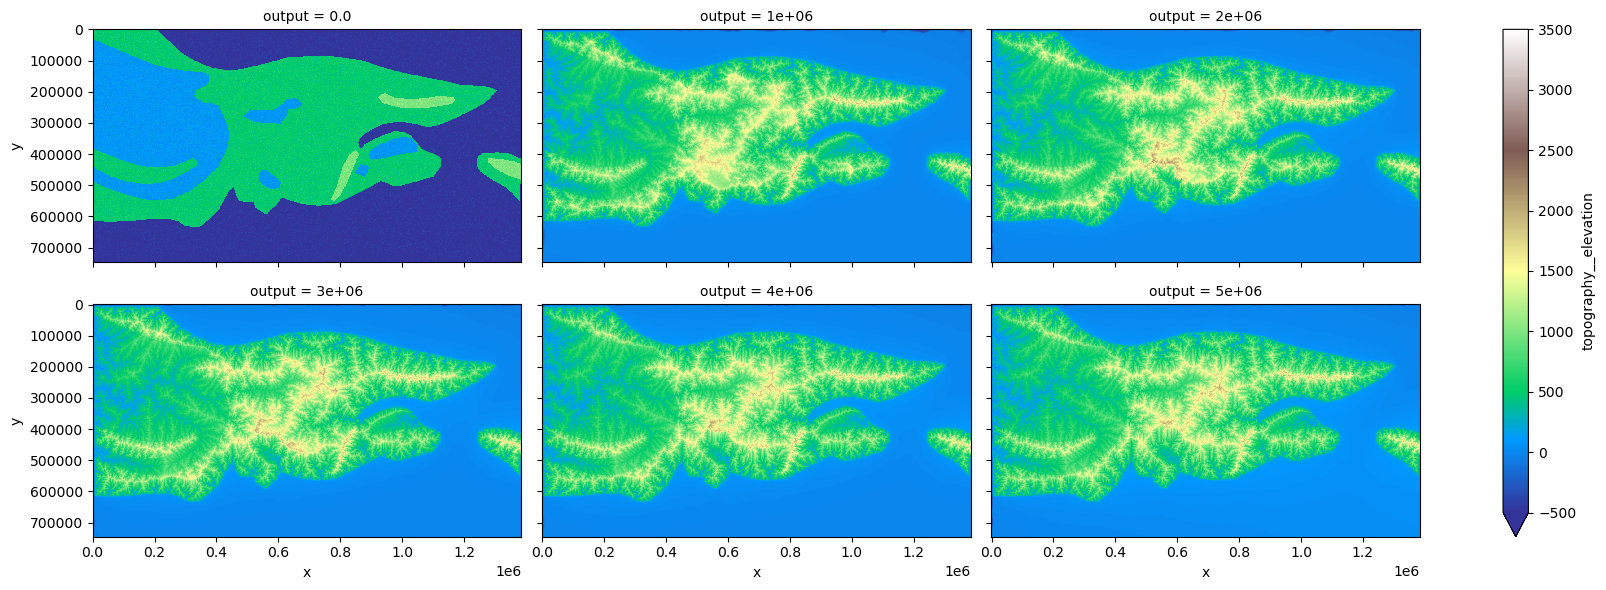

In [12]:
TimeSlices = np.arange(0, EndTime_1+1, 1e6)
out_ds_S1.sel(output=TimeSlices).topography__elevation.plot(col='output', col_wrap=3, aspect=ny/nx, cmap='terrain', vmin=-500, vmax=3500)

plt.gca().invert_yaxis()
plt.show()

/var/folders/k0/h0_nk0qn55q0z2tv6dwksnlc0000gq/T/ipykernel_7276/824127270.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax1, t in zip(fig1.axes.ravel(), time_sel):
/var/folders/k0/h0_nk0qn55q0z2tv6dwksnlc0000gq/T/ipykernel_7276/824127270.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  axs2_2.plot(dtf.groupby(['output']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 10015
                                                                               
                                                                               


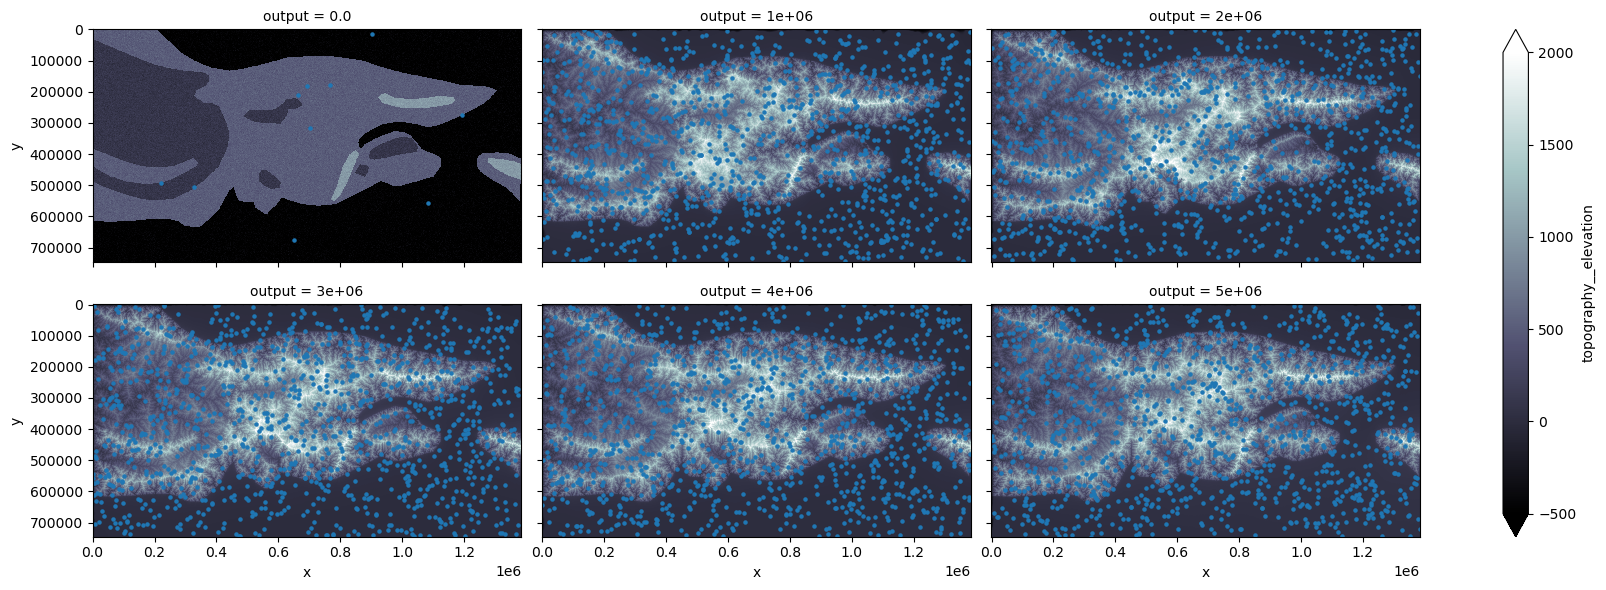

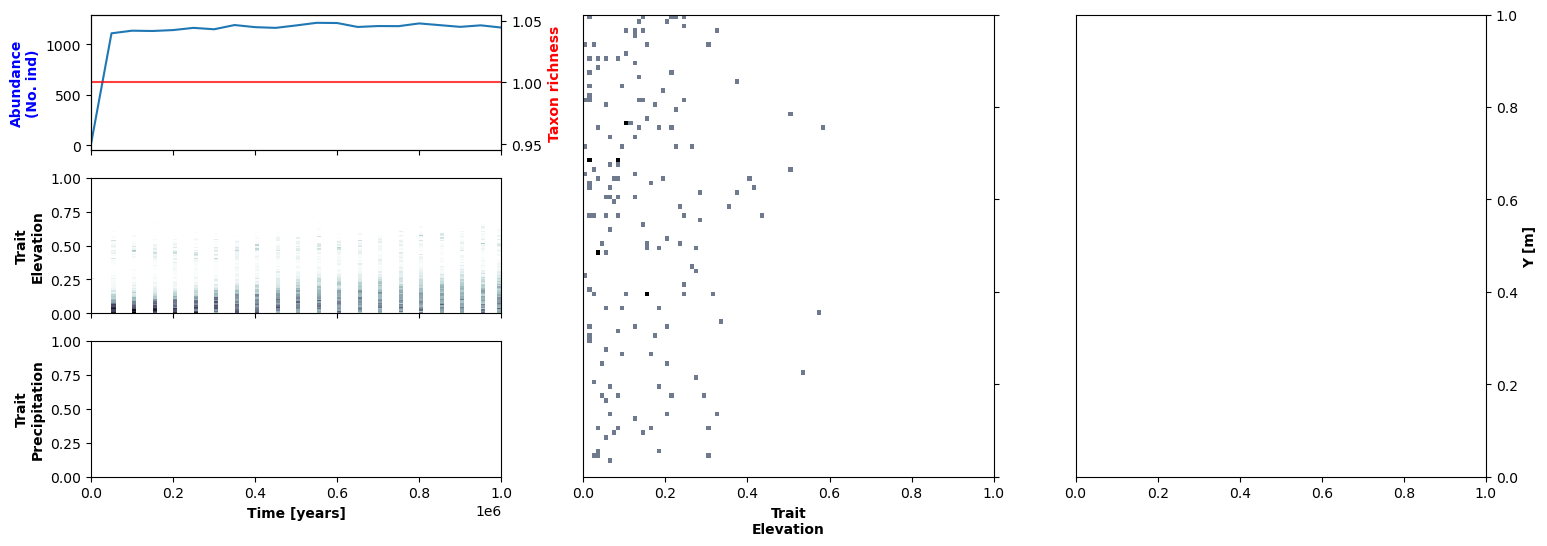

In [13]:
TurkeyLEM_Data = get_dataframe(out_ds_S1)
plot_topo_taxa(out_ds_S1, TurkeyLEM_Data, TimeSlices)
plt.gca().invert_yaxis()
plot_temp_dyn_2traits(TurkeyLEM_Data)
tree1 = TurkeyLEM_Data.rename(columns={'output':'time'}).ptree.to_dendropy_tree()
tree1.print_plot()

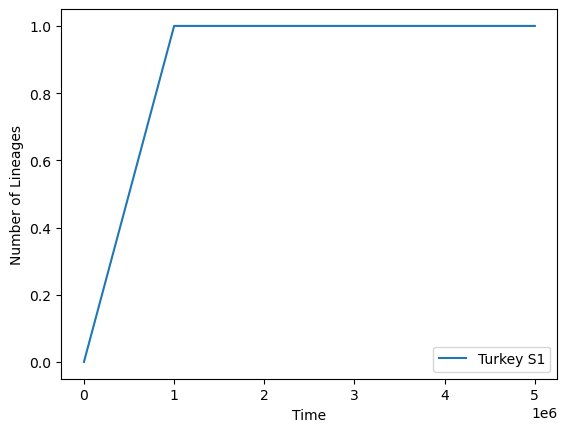

In [14]:
ltt1=[tree1.num_lineages_at(t) for t in TimeSlices]
plt.plot(TimeSlices, ltt1, label='Turkey S1')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [15]:
FinalTopography_S1 = out_ds_S1.topography__elevation[-1,:,:]
FinalBedrockTopography_S1 = out_ds_S1.bedrock__elevation[-1,:,:]

In [16]:
## Set up input parameters for xarray-simlab model ##
in_ds_S2 = xs.create_setup(
    model = TurkeyLEM,
    clocks={
        'time': ModelTime_2,
        'output': ModelTime_2[::PlotStep]
    },
    master_clock='time',
    input_vars={
        'grid': {
            'shape': [nx, ny],
            'length': [xl, yl],
        },
        'boundary': {
            'status': BoundaryCondition
        },
        'topography': {
            'elevation': FinalBedrockTopography_S1,
        },
        'bedrock': {
            'elevation': FinalBedrockTopography_S1,
        },
        'uplift': {
            'rate': SurfaceUplift_2,
        },
        'spl': {
            'k_coef': kf_bedrock,
            'area_exp': m,
            'slope_exp': n,
            'g_coef': g_bedrock,
        },
        'diffusion': {
            'diffusivity': kd_bedrock,
        },
        'marine': {
            'ss_ratio_land': Silt_FractionOnLand,
            'porosity_sand': Sand_Porosity,
            'porosity_silt': Silt_Porosity,
            'e_depth_sand': Sand_eDepth,
            'e_depth_silt': Silt_eDepth,
            # issue with diffusivity not being equal for both sand and silt, need to increase time steps, issues with sea level depths (too deep may crash the model)
            'diffusivity_sand': Sand_Diffusivity, 
            'diffusivity_silt': Silt_Diffusivity,
            'layer_depth': ActiveLayerDepth,
        },
        'life': {
            'init_abundance': InitialAbundance,
            'random_seed': RandomSeed,
            'taxon_threshold': TaxonThreshold,
            'taxon_def': TaxonDefinition,
            'init_x_range_min': InitialSpecies_xmin,
            'init_x_range_max': InitialSpecies_xmax,
            'init_y_range_min': InitialSpecies_ymin,
            'init_y_range_max': InitialSpecies_ymax,
            'rho': TraitCorrelationCoefficient,
            'sigma_u': TraitMediatedCompetition,
            'sigma_f': FitnessSelectivity,
            'sigma_d': DispersalVariability,
            'sigma_m': OffspringVariability,
            'p_m': MutationProbability,
            'r': NeighbourhoodRadius,
            'K': NeighbourhoodCapacity
        },
        'random': {
            'seed': RandomSeed,
        },
        'trait_elev': {
            'init_trait_min': InitialTraitMinimum,
            'init_trait_max': InitialTraitMaximum,
            'lin_slope': Slope_TraitvsElevation,
            'norm_min': MinimumElevationNormalisation,
            'norm_max': MaximumElevationNormalisation,
        },
    },
    output_vars={
        'topography': {
            'elevation': 'output'
        },
        'bedrock': {
            'elevation': 'output'
        },
        'life': {
            'x': 'output',
            'y': 'output',
            'traits': 'output',
            'taxon_id': 'output',
            'ancestor_id': 'output'
        }
    }
)

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'output' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [17]:
with xs.monitoring.ProgressBar():
    out_ds_S2 = in_ds_S2.xsimlab.run(model=TurkeyLEM)

out_ds_S2

             0% | initialize 

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


<xarray.Dataset> Size: 2GB
Dimensions:                     (output: 101, y: 745, x: 1384, border: 4,
                                 shape_yx: 2, ind: 1173, trait: 1, time: 10001)
Coordinates:
  * border                      (border) object 32B 'left' 'right' ... 'bottom'
  * output                      (output) float64 808B 0.0 5e+04 ... 5e+06
  * time                        (time) float64 80kB 0.0 500.0 ... 5e+06 5e+06
  * trait                       (trait) object 8B b'trait_elev'
  * x                           (x) float64 11kB 0.0 1.001e+03 ... 1.384e+06
  * y                           (y) float64 6kB 0.0 1.001e+03 ... 7.45e+05
Dimensions without coordinates: shape_yx, ind
Data variables: (12/50)
    bedrock__elevation          (output, y, x) float64 833MB -440.9 ... 2.178...
    boundary__status            (border) <U11 176B 'fixed_value' ... 'core'
    diffusion__diffusivity      float64 8B 2e-06
    grid__length                (shape_yx) float64 16B 7.45e+05 1.384e+06
    grid__shape                 (shape_yx) int64 16B 745 1384
    life__K                     int64 8B 25
    ...                          ...
    trait_elev__init_trait_max  float64 8B 0.25
    trait_elev__init_trait_min  float64 8B 0.25
    trait_elev__lin_slope       float64 8B 0.95
    trait_elev__norm_max        int64 8B 3700
    trait_elev__norm_min        int64 8B 0
    uplift__rate                (y, x) float64 8MB 0.0025 0.0025 ... 0.0025

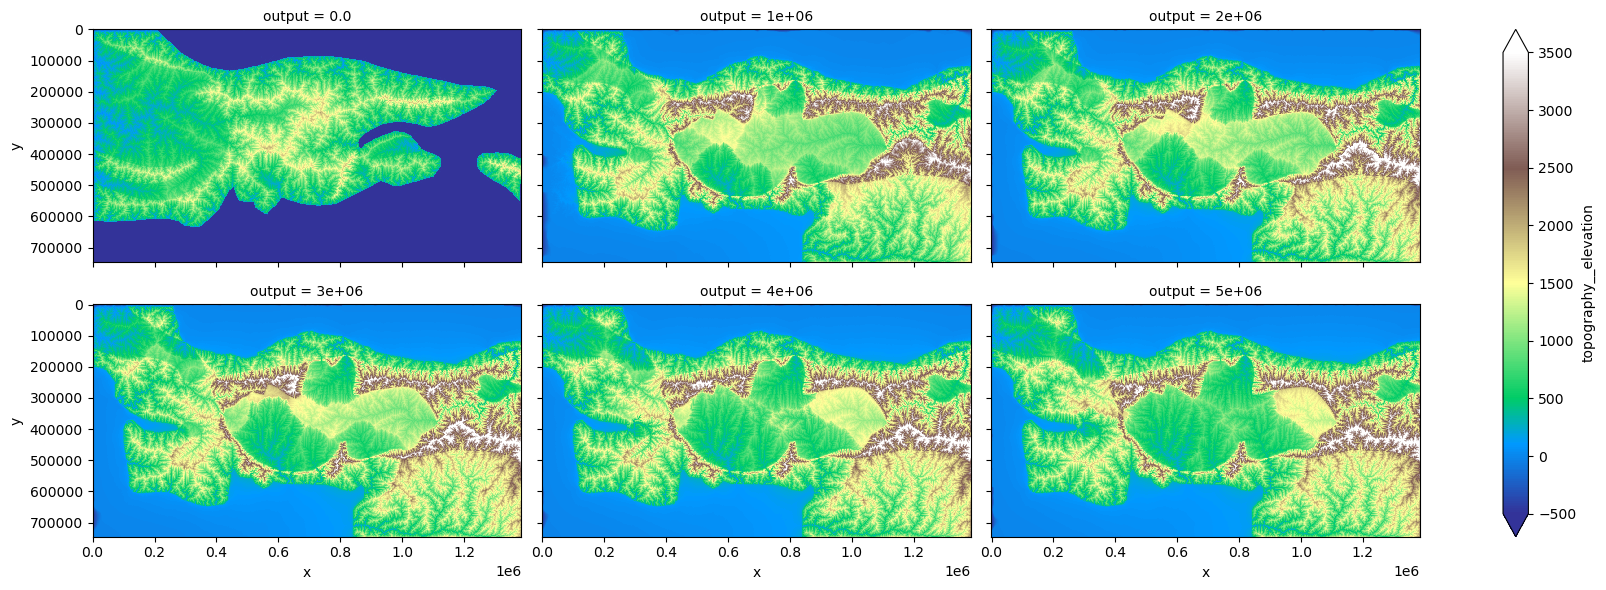

In [18]:
TimeSlices = np.arange(0, EndTime_1+1, 1e6)
out_ds_S2.sel(output=TimeSlices).topography__elevation.plot(col='output', col_wrap=3, aspect=ny/nx, cmap='terrain', vmin=-500, vmax=3500)
plt.gca().invert_yaxis()
plt.show()

/var/folders/k0/h0_nk0qn55q0z2tv6dwksnlc0000gq/T/ipykernel_7276/824127270.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax1, t in zip(fig1.axes.ravel(), time_sel):
/var/folders/k0/h0_nk0qn55q0z2tv6dwksnlc0000gq/T/ipykernel_7276/824127270.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  axs2_2.plot(dtf.groupby(['output']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)


               /--------------------------------------------------------- 2336 
               |                                                               
               |                           /----------------------------- 7167 
               |                           |                                   
               |                /+++++++++++               /------------- 9804 
++++++++++++++++                |          |         /++++++                   
               |                |          |         |     |        /---+ 11282
               |                |          +++++++++++     \+++++++++          
               |      /++++++++++                    |              \++++ 11824
               |      |         |                    |                         
               |      |         |                    \------------------+ 8867 
               \+++++++         |                                              
                      |         \-------

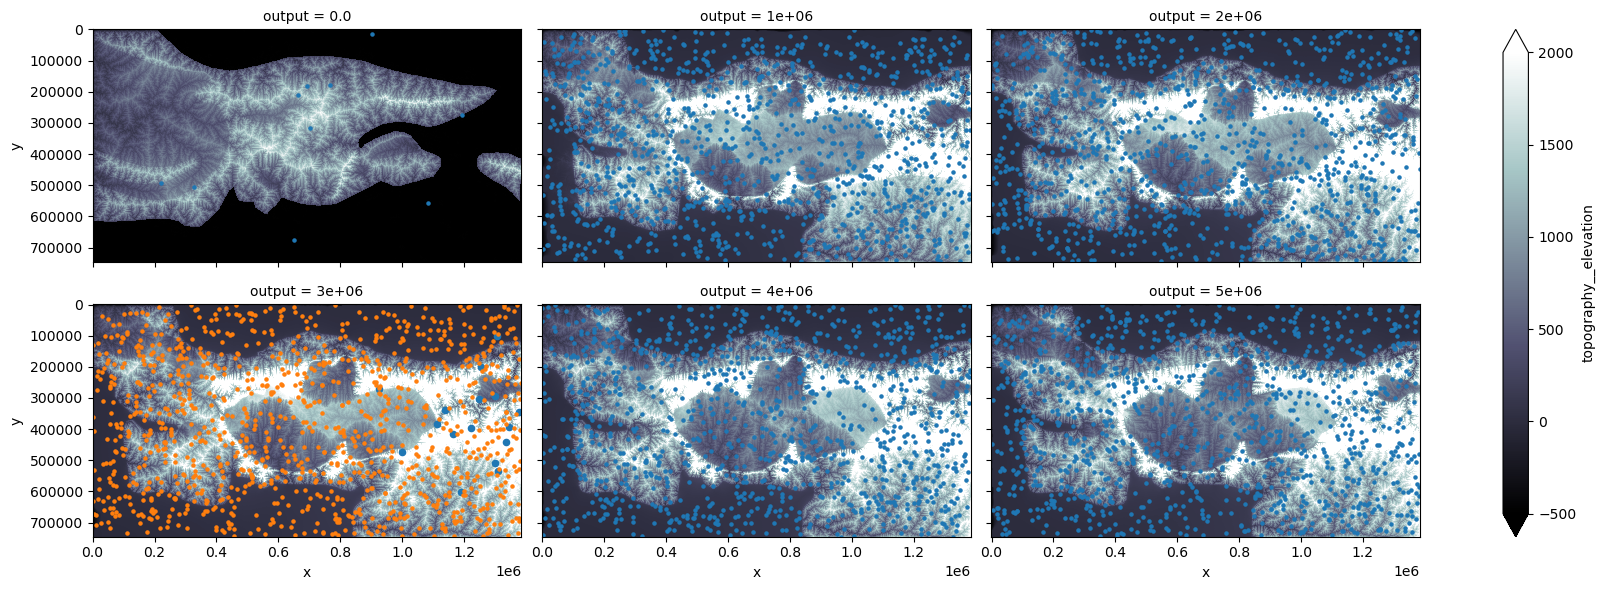

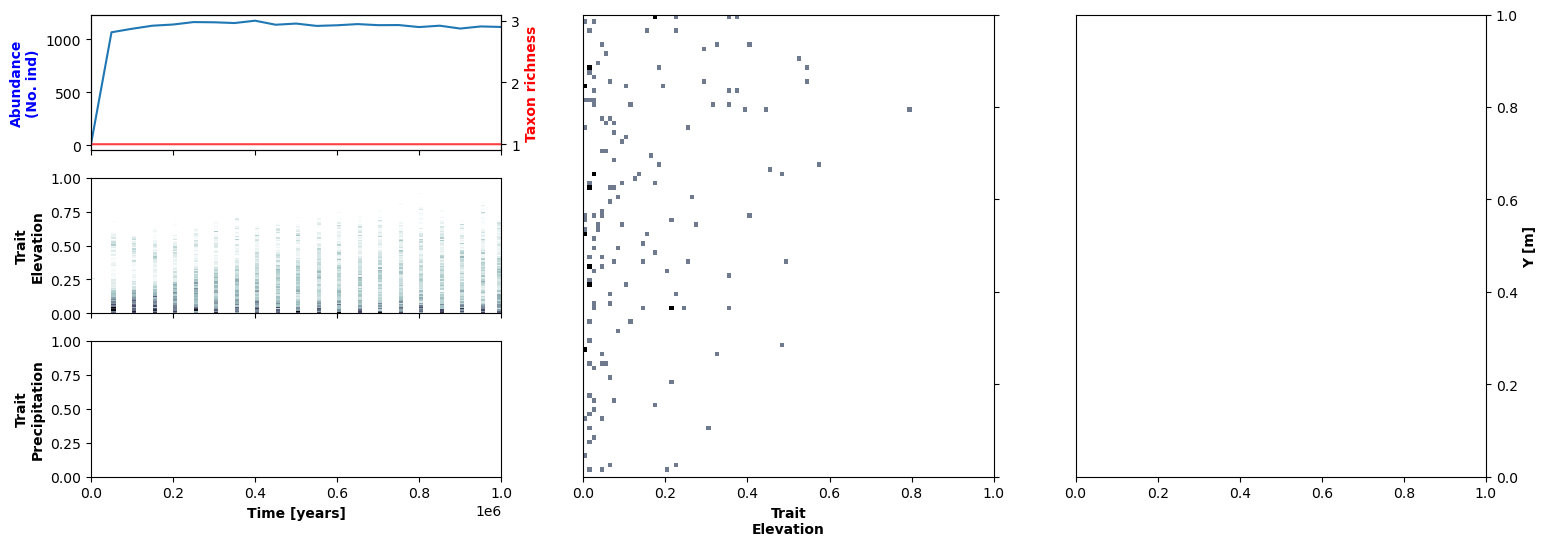

In [19]:
TurkeyLEM_Data = get_dataframe(out_ds_S2)
plot_topo_taxa(out_ds_S2, TurkeyLEM_Data, TimeSlices)
plt.gca().invert_yaxis()
plot_temp_dyn_2traits(TurkeyLEM_Data)
tree2 = TurkeyLEM_Data.rename(columns={'output':'time'}).ptree.to_dendropy_tree()
tree2.print_plot()

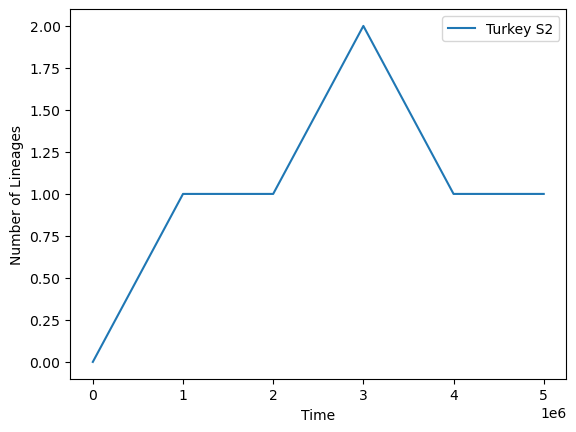

In [20]:
ltt2=[tree2.num_lineages_at(t) for t in TimeSlices]
plt.plot(TimeSlices, ltt2, label='Turkey S2')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [21]:
FinalTopography_S2 = out_ds_S2.topography__elevation[-1,:,:]
FinalBedrockTopography_S2 = out_ds_S2.bedrock__elevation[-1,:,:]

In [22]:
## Set up input parameters for xarray-simlab model ##
in_ds_S3 = xs.create_setup(
    model = TurkeyLEM,
    clocks={
        'time': ModelTime_3,
        'output': ModelTime_3[::PlotStep]
    },
    master_clock='time',
    input_vars={
        'grid': {
            'shape': [nx, ny],
            'length': [xl, yl],
        },
        'boundary': {
            'status': BoundaryCondition
        },
        'topography': {
            'elevation': FinalBedrockTopography_S2,
        },
        'bedrock': {
            'elevation': FinalBedrockTopography_S2,
        },
        'uplift': {
            'rate': SurfaceUplift_3,
        },
        'spl': {
            'k_coef': kf_bedrock,
            'area_exp': m,
            'slope_exp': n,
            'g_coef': g_bedrock,
        },
        'diffusion': {
            'diffusivity': kd_bedrock,
        },
        'marine': {
            'ss_ratio_land': Silt_FractionOnLand,
            'porosity_sand': Sand_Porosity,
            'porosity_silt': Silt_Porosity,
            'e_depth_sand': Sand_eDepth,
            'e_depth_silt': Silt_eDepth,
            # issue with diffusivity not being equal for both sand and silt, need to increase time steps, issues with sea level depths (too deep may crash the model)
            'diffusivity_sand': Sand_Diffusivity, 
            'diffusivity_silt': Silt_Diffusivity,
            'layer_depth': ActiveLayerDepth,
        },
        'life': {
            'init_abundance': InitialAbundance,
            'random_seed': RandomSeed,
            'taxon_threshold': TaxonThreshold,
            'taxon_def': TaxonDefinition,
            'init_x_range_min': InitialSpecies_xmin,
            'init_x_range_max': InitialSpecies_xmax,
            'init_y_range_min': InitialSpecies_ymin,
            'init_y_range_max': InitialSpecies_ymax,
            'rho': TraitCorrelationCoefficient,
            'sigma_u': TraitMediatedCompetition,
            'sigma_f': FitnessSelectivity,
            'sigma_d': DispersalVariability,
            'sigma_m': OffspringVariability,
            'p_m': MutationProbability,
            'r': NeighbourhoodRadius,
            'K': NeighbourhoodCapacity
        },
        'random': {
            'seed': RandomSeed,
        },
        'trait_elev': {
            'init_trait_min': InitialTraitMinimum,
            'init_trait_max': InitialTraitMaximum,
            'lin_slope': Slope_TraitvsElevation,
            'norm_min': MinimumElevationNormalisation,
            'norm_max': MaximumElevationNormalisation,
        },
    },
    output_vars={
        'topography': {
            'elevation': 'output'
        },
        'bedrock': {
            'elevation': 'output'
        },
        'life': {
            'x': 'output',
            'y': 'output',
            'traits': 'output',
            'taxon_id': 'output',
            'ancestor_id': 'output'
        }
    }
)

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'output' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


: 

In [23]:
with xs.monitoring.ProgressBar():
    out_ds_S3 = in_ds_S3.xsimlab.run(model=TurkeyLEM)

out_ds_S3

             0% | initialize 

/opt/homebrew/Caskroom/miniconda/base/envs/FastScape/lib/python3.9/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


In [ ]:
TimeSlices = np.arange(0, EndTime_3+1, 1e6)
out_ds_S3.sel(output=TimeSlices).topography__elevation.plot(col='output', col_wrap=3, aspect=ny/nx, cmap='terrain', vmin=-500, vmax=3500)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
TurkeyLEM_Data = get_dataframe(out_ds_S3)
plot_topo_taxa(out_ds_S3, TurkeyLEM_Data, TimeSlices)
plt.gca().invert_yaxis()
plot_temp_dyn_2traits(TurkeyLEM_Data)
tree3 = TurkeyLEM_Data.rename(columns={'output':'time'}).ptree.to_dendropy_tree()
tree3.print_plot()

In [ ]:
ltt3=[tree3.num_lineages_at(t) for t in TimeSlices]
plt.plot(TimeSlices, ltt3, label='Turkey S3')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()